# Geocode SLCs for NISAR-simulated UAVSAR data


Information on NISAR-sample products, created from past UAVSAR flights:
https://uavsar.jpl.nasa.gov/science/documents/nisar-sample-products.html

Each product is stored as an HDF5 file (though the flat binary formats are also available). There are multiple "modes" to choose from with different bandwidths:

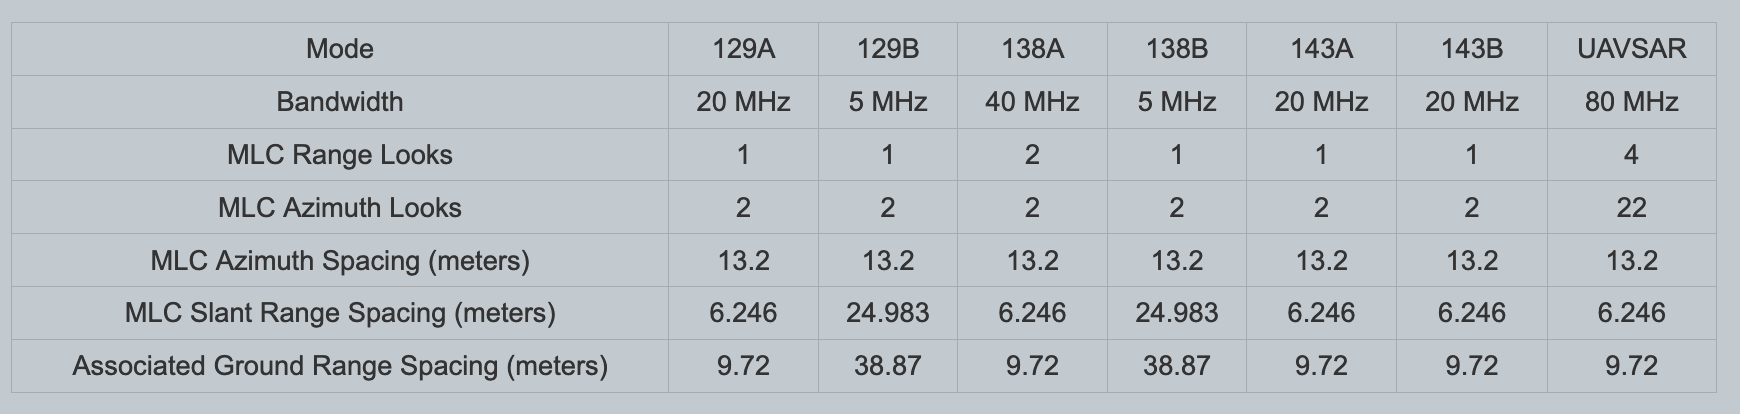

The "A" and "B" are from the low and high end of the spectrum, so for our purposes, we only need one. Since we're just doing a demonstration with 2 SLCs, we'll choose the 20 MHz version from mode 129A, which will be half the size of the 40 MHz version (138A).

# Setup and Installation

UAVSAR query/download tool, and geocoded SLC (GSLC) converter, are in https://github.com/scottstanie/uavsar/


Scott's preferences for setting up environments:

- I use miniconda to install packages into my environment (this is widely used for geospatial packages, due to annoying build dependencies)
- The first thing I install is [mamba](https://github.com/mamba-org/mamba), which makes it possible to install/ add new packages to an existing environment in seconds to minutes, as opposed to hours. This isn't as widely used, but I think it should be.


After getting set up with [miniconda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html), I would create my environment (called `mapping` here) as follows:

(*Note*: Commands listed with a `$` indicate a bash command to run in your terminal.):

```
$ conda config --add channels conda-forge
$ conda create -n mapping --yes python=3.8 pip mamba
$ conda activate mapping
```

Using anaconda isn't necessary to run the geocoder (and definitely not for the data downloader), but it will make things much easier to install for GPU support.

## Extra installation: Running on the GPU with Numba's CUDA support

(Skip this if you have no interest running on the GPU.)

If you have an NVIDIA GPU, the `uageocode` has been written to use the GPU using Numba. It is *possible* that, on a computer where the appropriate CUDA libraries are set up, you could simply do `pip install numba` and it would work. However, it's often easier to use conda to install.

From  https://numba.pydata.org/numba-doc/latest/user/installing.html :


> To enable CUDA GPU support for Numba, install the latest graphics drivers from NVIDIA for your platform. (Note that the open source Nouveau drivers shipped by default with many Linux distributions do not support CUDA.) Then install the cudatoolkit package:


```
$ conda install numba
$ conda install cudatoolkit
```


> You do not need to install the CUDA SDK from NVIDIA.

## Getting the `uavsar` repository


We will run the terminal here in the Jupyter using the `!` feature

In [1]:
import os
import sys

# to clone the repository somehwere besides "~/repos", change these first two lines
!mkdir -p ~/repos/ 

In [3]:
# note: the directory changing needs to happen here for it to persist with Jupyter
os.chdir(os.path.expanduser("~/repos/"))

In [32]:
!git clone https://github.com/scottstanie/uavsar/

fatal: destination path 'uavsar' already exists and is not an empty directory.


In [143]:
os.chdir(os.path.expanduser("~/repos/uavsar"))

In [144]:
!pip install .[geoslc]

Processing /home/scott/repos/uavsar
  Created wheel for uavsar: filename=uavsar-0.1.0-py3-none-any.whl size=25976 sha256=7cb0b7b516821c167f17223b58f24541598ab5a0d86cd8e5f71532ab63769ed1
  Stored in directory: /tmp/pip-ephem-wheel-cache-x488ze06/wheels/7e/a0/4b/072725d2c4b9c3b8d98f7c9cad1defe14890b5d81054451000
Successfully built uavsar
  Attempting uninstall: uavsar
    Found existing installation: uavsar 0.1.0
    Uninstalling uavsar-0.1.0:
      Successfully uninstalled uavsar-0.1.0


The `.[geoslc]` is for the extra requirements (numpy, h5py, and numba) that are needed beyond just the query tool installation.

This installation will put two executables on your path:

1. `uaquery`: UAVSAR data query tool
2. `uageocode`: tool to create geocoded SLCs from the HDF5 NISAR products


In [25]:
# Test out the installation
!uaquery --help

usage: uaquery [-h] [--file-type FILE_TYPE] [--start-date START_DATE]
               [--end-date END_DATE]
               [--nisar-mode {129a,129b,138a,138b,143a,143b}]
               [--pol {hh,hv,vh,vv,hhhh,hvhv,vvvv,hhhv,hhvv,hvvv}]
               [--out-dir OUT_DIR] [--query-only] [--url-file URL_FILE]
               [--quiet]
               flight_line

positional arguments:
  flight_line           UAVSAR flight line

optional arguments:
  -h, --help            show this help message and exit
  --file-type FILE_TYPE
                        Extension of radar product (default=ann)
  --start-date START_DATE
                        Starting date for query (formats accepts: YYYYMMDD,
                        YYYY-MM-DD, yymmdd)
  --end-date END_DATE   Ending date for query (formats accepts: YYYYMMDD,
                        YYYY-MM-DD, yymmdd)
  --nisar-mode {129a,129b,138a,138b,143a,143b}
                        If searching for NISAR-simulated products, NISAR mode
                   

In [26]:
# Test out the installation
!uageocode --help

usage: uageocode [-h] [--demfile DEMFILE] [--pol {HH,HV,VH,VV}]
                 [--frequency {A,B}] [--outfile OUTFILE] [--gpu]
                 hdf5_file

positional arguments:
  hdf5_file             UAVSAR HDF5 file containing SLCs

optional arguments:
  -h, --help            show this help message and exit
  --demfile DEMFILE, -d DEMFILE
                        Filename of DEM to use for geocoding
                        (default=elevation.dem)
  --pol {HH,HV,VH,VV}   Polarization (default=VV)
  --frequency {A,B}     Frequency band to use ( choices = A, B, default=A)
  --outfile OUTFILE, -o OUTFILE
                        File to save output (default =
                        '{hdf5_file}_frequency{frequency}_{pol}.geo.slc')
  --gpu                 Geocode on the GPU (requires numba/cuda installation),
                        See https://numba.readthedocs.io/en/stable/cuda/overvi
                        ew.html#requirements


# Data download

We'll use data from the `Snjoaq` campaign, flight number 14511, over the Central Valley of California:

https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=Snjoaq_14511_14005_012_140117_L090_CX_03#data

There are 22 passes from 7/2013 to 11/2018 that have been converted into the NISAR-simulated format.
We will use the `uaquery` utility in the uavsar repo to download just 2 SLCs to test out the conversion from range-doppler SLC to GSLC.

In [146]:
# CHANGE ME: choose a good working directory
WORKDIR = "/data6/scott/jpl/snjoaq-gslc-test"
os.chdir(WORKDIR)

In [57]:
!uaquery 14511 --start-date 2013-07-01 --end-date 2013-11-01 --nisar-mode 129a --file-type h5 --query-only

[08/16 19:07:20] [INFO cli.py] Arguments for search:
[08/16 19:07:20] [INFO cli.py] {'flight_line': 14511, 'file_type': 'h5', 'start_date': datetime.datetime(2013, 7, 1, 0, 0), 'end_date': datetime.datetime(2013, 11, 1, 0, 0), 'nisar_mode': '129a', 'pol': 'vv', 'out_dir': '.', 'query_only': True, 'url_file': 'uavsar_download_urls_{file_type}{pol}{nisar_mode}.txt', 'quiet': False, 'verbose': True}
[08/16 19:07:20] [INFO cli.py] Only finding URLs for download:
[08/16 19:07:20] [INFO query_uavsar.py] url_file = uavsar_download_urls_h5129a.txt
[08/16 19:07:20] [INFO query_uavsar.py] Querying https://uavsar.jpl.nasa.gov/cgi-bin/data.pl?fname=searchUavsar&args=14511&searchText=14511&args=130701&startDate=130701&args=131101&endDate=131101&args=PolSAR&modeList=PolSAR&args=L-band%2Csimulated-nisar&bandList=L-band%2Csimulated-nisar&args=single-pol%2Cquad-pol&polList=single-pol%2Cquad-pol&args=14511&flownData=14511&args=14511&lineID=14511&args=simulated-nisar&simulatedNisar=simulated-nisar
[08/16

We used the `--query-only` option to check what products were found, which are saved to a file:

In [58]:
!ls

uavsar_download_urls_h5129a.txt


In [59]:
!cat uavsar_download_urls_h5129a.txt

http://downloaduav.jpl.nasa.gov/Release2f/Snjoaq_14511_13129_010_130719_L090_CX_03/Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5
http://downloaduav.jpl.nasa.gov/Release2f/Snjoaq_14511_13165_012_131031_L090_CX_03/Snjoaq_14511_13165_012_131031_L090_CX_129_03.h5


So we found 2 SLC products. Let's download them by taking out the "--query-only" part from the command (this will take a few minutes, each HDF5 file is 3 GB):

In [60]:
%%time
!uaquery 14511 --start-date 2013-07-01 --end-date 2013-11-01 --nisar-mode 129a --file-type h5

[08/16 19:07:30] [INFO cli.py] Arguments for search:
[08/16 19:07:30] [INFO cli.py] {'flight_line': 14511, 'file_type': 'h5', 'start_date': datetime.datetime(2013, 7, 1, 0, 0), 'end_date': datetime.datetime(2013, 11, 1, 0, 0), 'nisar_mode': '129a', 'pol': 'vv', 'out_dir': '.', 'query_only': False, 'url_file': 'uavsar_download_urls_{file_type}{pol}{nisar_mode}.txt', 'quiet': False, 'verbose': True}
[08/16 19:07:30] [INFO cli.py] Searching and downloading to .
[08/16 19:07:30] [INFO query_uavsar.py] url_file = uavsar_download_urls_h5129a.txt
[08/16 19:07:30] [INFO query_uavsar.py] Found existing uavsar_download_urls_h5129a.txt to read from.
[08/16 19:07:30] [INFO query_uavsar.py] wget --no-clobber http://downloaduav.jpl.nasa.gov/Release2f/Snjoaq_14511_13129_010_130719_L090_CX_03/Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5
--2021-08-16 19:07:30--  http://downloaduav.jpl.nasa.gov/Release2f/Snjoaq_14511_13129_010_130719_L090_CX_03/Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5
Resolvin

# GSLC processing

The geocoded SLCs have the topographic phase removed, which allows us to comply load and cross-multiply two files to create an interferogram. 
This means we will need a digital elevation model (DEM) for our study area.

Another nice benefit of the GSLC approach, besides the interferogram simplicity: we do not need to process the entire flight line. We can make a DEM which only covers our area of interest, and it will geocode only the relevant part of the SLC.

There are multiply ways to make a DEM; I use my package [sardem](https://github.com/scottstanie/sardem), which can be installed through pip:

In [63]:
!pip install sardem
!sardem --help


usage: sardem [-h] [--bbox left bottom right top] [--geojson GEOJSON]
              [--xrate XRATE] [--yrate YRATE] [--output OUTPUT]
              [--data-source {NASA,NASA_WATER,AWS}] [--convert-to-wgs84]
              [left_lon] [top_lat] [dlon] [dlat]

Stiches SRTM .hgt files to make (upsampled) DEM

    Pick a lat/lon bounding box for a DEM, and it will download
    the necessary SRTM1 tiles, stitch together, then upsample.

    Usage Examples:
        sardem --bbox -156 18.8 -154.7 20.3  # bounding box: left  bottom  right top
        sardem -156.0 20.2 1 2 --xrate 2 --yrate 2  # Makes a box 1 degree wide, 2 deg high
        sardem --geojson dem_area.geojson -x 11 -y 3
        sardem -156.0 20.2 0.5 0.5 -r 10 --data-source NASA_WATER -o my_watermask.wbd # Water mask

    Default out is elevation.dem for the final upsampled DEM.
    Also creates elevation.dem.rsc with start lat/lon, stride, and other info.

positional arguments:
  left_lon              Left (western) most longitud

For this example, we'll make an interferogram targeting the Avenal subsidence feature around the CA aqueduct, from Miller et al., 2020:

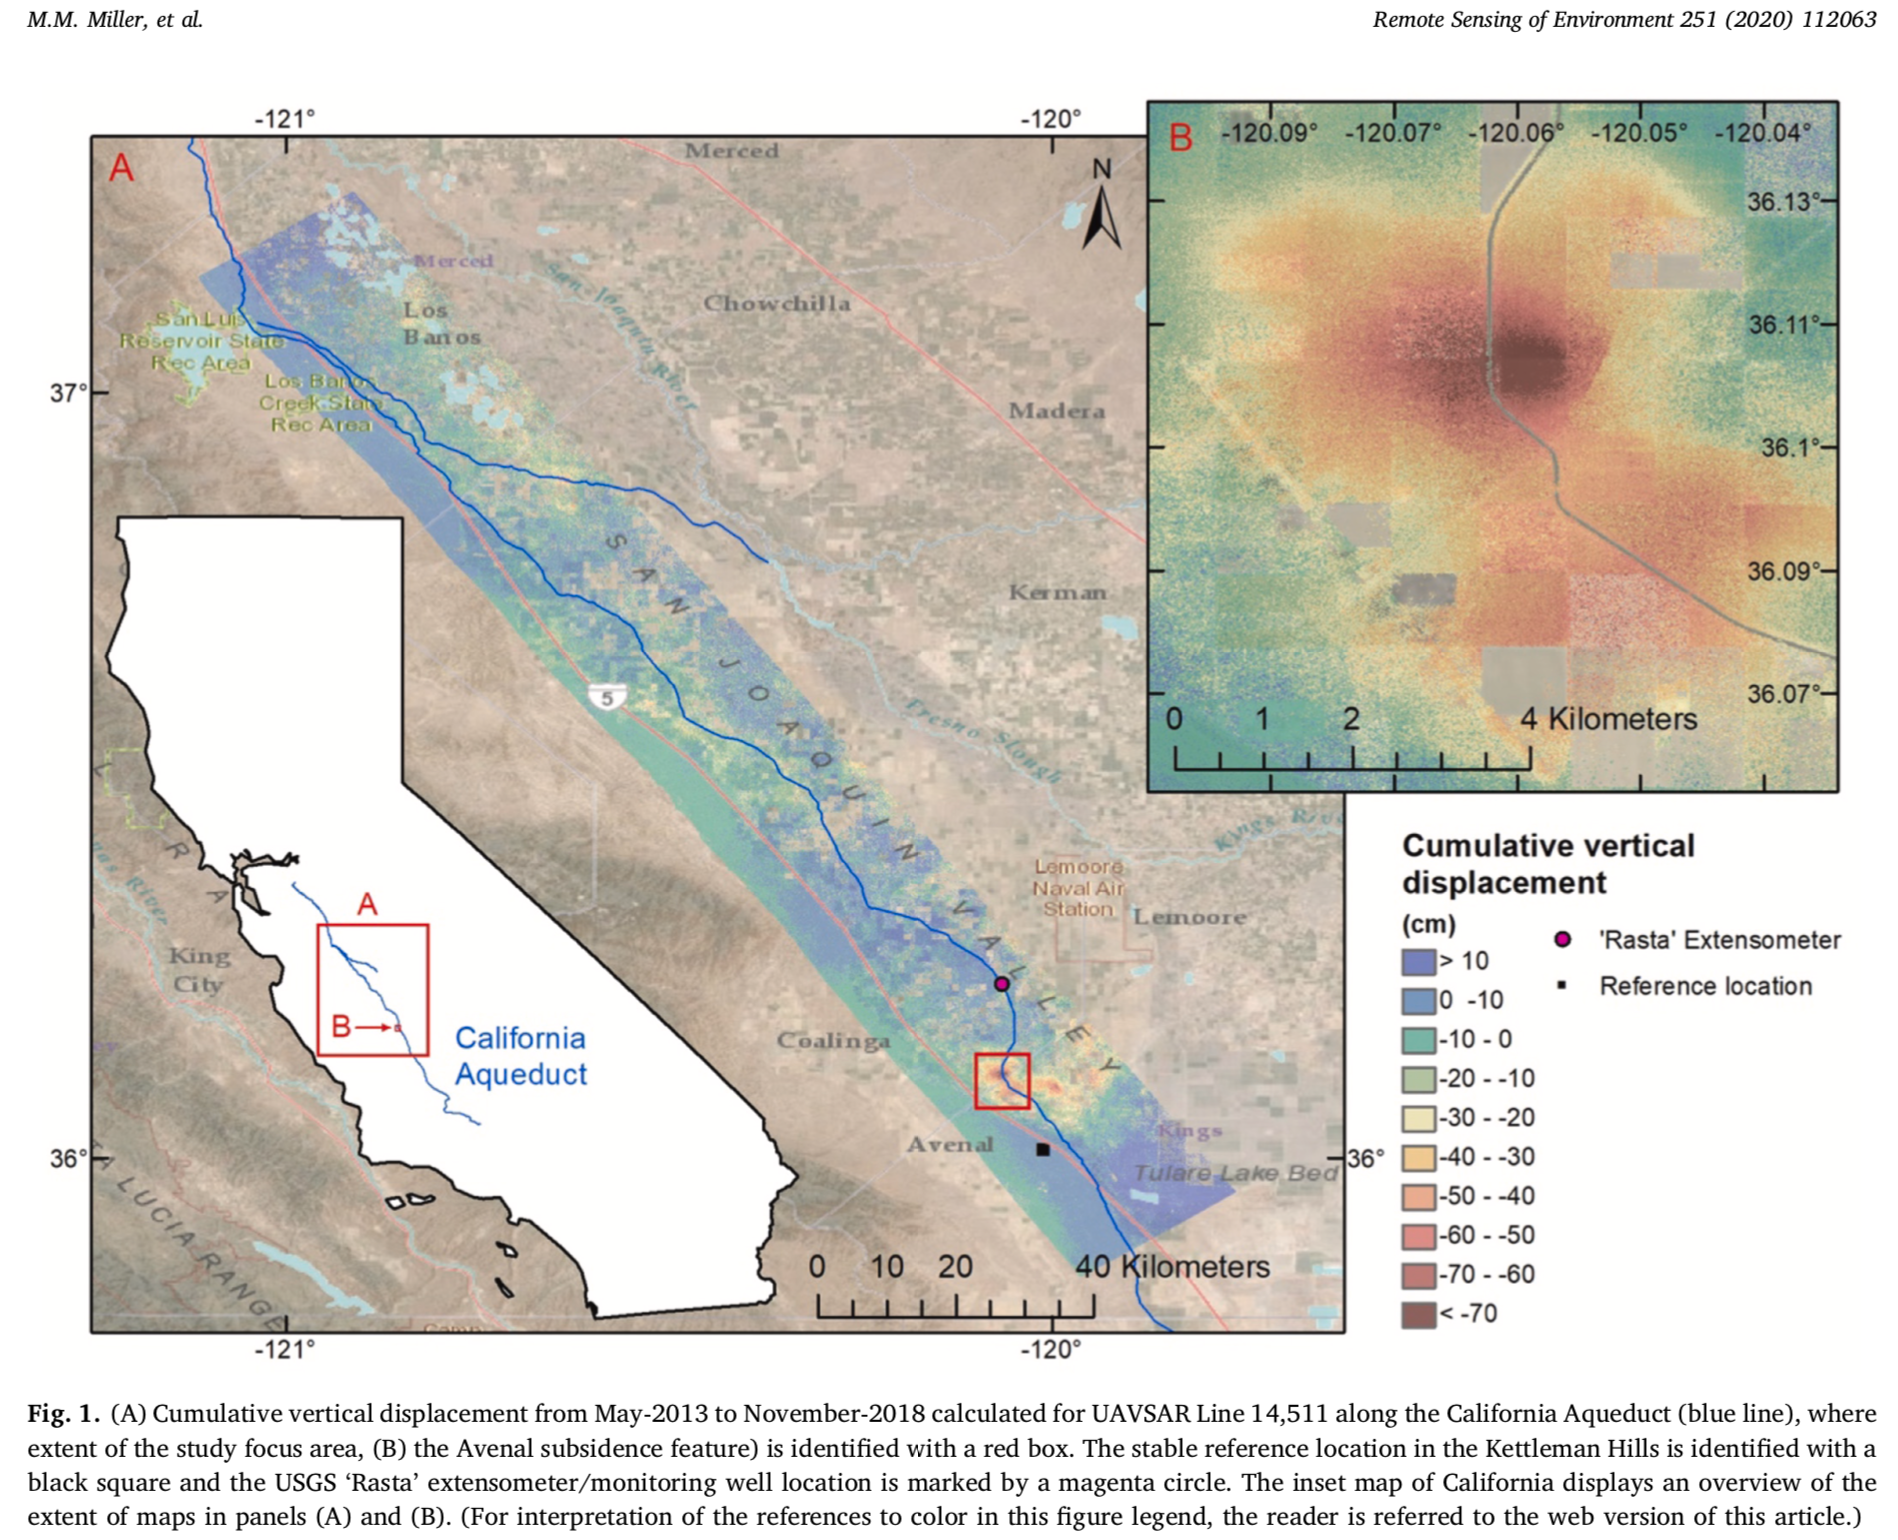

<div class="alert alert-info">
DEM Upsampling
</div>

The SRTM DEM has pixel spacing of 30 x 30 meters in latitude and longitude. Most radar systems have finer resolution than that, so we will upsample the DEM appropriately. We can upsample slightly more than the native SAR range/azimuth pixel spacing, and the data values will just be linearly interpolated (i.e. we may have more "looks" but not a higher "equivalent number of looks").

The 129A mode has 20 MHz bandwidth, which (according to https://uavsar.jpl.nasa.gov/science/documents/nisar-sample-products.html), has azimuth spacing of 6.1 m and slant range spacing of 6.2 meters. Thus, we will upsample by 5 in each direction

In [64]:
# The SRTM comes with heights above the EGM96 ellipsoid. 
# We will change this to the WGS84 heights for InSAR processing.
!sardem --bbox -120.17 36.0 -120.0 36.16 --xrate 5 --yrate 5 --convert-to-wgs84

[08/16 19:22:48] [INFO dem.py] Bounds: -120.17 36.0 -120.0 36.16
[08/16 19:22:48] [INFO download.py] /home/scott/.cache/sardem/N36W121.hgt already exists, skipping.
[08/16 19:22:49] [INFO dem.py] Cropping stitched DEM to boundaries
[08/16 19:22:49] [INFO dem.py] Upsampling by (5, 5) in (x, y) directions
[08/16 19:22:49] [INFO dem.py] Writing non-upsampled dem temporarily to small_elevation.dem
[08/16 19:22:49] [INFO dem.py] Writing non-upsampled dem.rsc temporarily to small_elevation.dem.rsc
[08/16 19:22:49] [INFO dem.py] Writing new upsampled dem.rsc to elevation.dem.rsc
New size of upsampled DEM: 2881 rows, 3061 cols.
Finished with upsampling, writing to disk
elevation.dem write complete.
[08/16 19:22:49] [INFO dem.py] Cleaning up small_elevation.dem and small_elevation.dem.rsc
[08/16 19:22:49] [INFO dem.py] Correcting DEM to heights above WGS84 ellipsoid
out
[08/16 19:22:49] [INFO conversions.py] Shifting elevation.dem.rsc for GDAL conversion by half pixel to edges
[08/16 19:22:49] 

In [66]:
!ls

elevation.dem	   Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5
elevation.dem.rsc  Snjoaq_14511_13165_012_131031_L090_CX_129_03.h5
elevation.hdr	   uavsar_download_urls_h5129a.txt


Now we have all the files we need for the geocoder

# Geocoding SLCs

We can adjust the polarization choice, or frequency (A/B) via the command line options. But we will use the defaults to start.

In [68]:
!uageocode --help

usage: uageocode [-h] [--demfile DEMFILE] [--pol {HH,HV,VH,VV}]
                 [--frequency {A,B}] [--outfile OUTFILE] [--gpu]
                 hdf5_file

positional arguments:
  hdf5_file             UAVSAR HDF5 file containing SLCs

optional arguments:
  -h, --help            show this help message and exit
  --demfile DEMFILE, -d DEMFILE
                        Filename of DEM to use for geocoding
                        (default=elevation.dem)
  --pol {HH,HV,VH,VV}   Polarization (default=VV)
  --frequency {A,B}     Frequency band to use ( choices = A, B, default=A)
  --outfile OUTFILE, -o OUTFILE
                        File to save output (default =
                        '{hdf5_file}_frequency{frequency}_{pol}.geo.slc')
  --gpu                 Geocode on the GPU (requires numba/cuda installation),
                        See https://numba.readthedocs.io/en/stable/cuda/overvi
                        ew.html#requirements


In [147]:
%%time
!uageocode Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5 

[08/17 12:24:10] [INFO geocode_slc.py] Writing results to Snjoaq_14511_13129_010_130719_L090_CX_129_03frequencyA_VV.geo.slc
[08/17 12:24:10] [INFO geocode_slc.py] Near, far range, delta_r: 13150.5653, 29632.904812912, 6.245676208000077
[08/17 12:24:10] [INFO geocode_slc.py] Start, end pulse times, PRI: 172800.0, 173584.2922078032, 0.025047656090464443
[08/17 12:24:10] [INFO geocode_slc.py] Loading SLC:
[08/17 12:24:11] [INFO geocode_slc.py] slc.shape = (31313, 2640)
[08/17 12:24:11] [INFO geocode_slc.py] Dumping SLC to ./joblib_memmap/tmp.slc
[08/17 12:24:11] [INFO geocode_slc.py] Memmapping SLC and DEM
Processing row 0 / 2881
Processing row 100 / 2881
Processing row 200 / 2881
Processing row 300 / 2881
Processing row 400 / 2881
Processing row 500 / 2881
Processing row 600 / 2881
Processing row 700 / 2881
Processing row 800 / 2881
Processing row 900 / 2881
Processing row 1000 / 2881
Processing row 1100 / 2881
Processing row 1200 / 2881
Processing row 1300 / 2881
Processing row 1400 / 2

So the CPU version takes about 10-12 seconds to create the cropped GSLC, as we're looking at a relatively small area.

Let's try out the GPU version.

In [134]:
%%time
!uageocode Snjoaq_14511_13165_012_131031_L090_CX_129_03.h5 --gpu

[08/17 12:12:22] [INFO geocode_slc.py] Writing results to Snjoaq_14511_13165_012_131031_L090_CX_129_03frequencyA_VV.geo.slc
[08/17 12:12:22] [INFO geocode_slc.py] Near, far range, delta_r: 13150.2168, 29632.556312912, 6.245676208000077
[08/17 12:12:22] [INFO geocode_slc.py] Start, end pulse times, PRI: 172800.0, 173515.1796572736, 0.0228696487902198
[08/17 12:12:22] [INFO geocode_slc.py] Loading SLC:
[08/17 12:12:23] [INFO geocode_slc.py] slc.shape = (31273, 2640)
[08/17 12:12:23] [INFO geocode_slc.py] Loading DEM:
[08/17 12:12:23] [INFO geocode_slc.py] dem.shape = (2881, 3061)
[08/17 12:12:23] [INFO geocode_slc.py] Geocoding and phase compensating SLC on GPU
[08/17 12:12:23] [INFO geocode_slc.py] (blocks per grid, threads per block) = ((181, 192), (16, 16))
[08/17 12:12:25] [INFO logger.py] Total elapsed time for main : 0.04 minutes (2.59 seconds)
CPU times: user 70.2 ms, sys: 59.2 ms, total: 129 ms
Wall time: 3.59 s


This takes only 3-4 seconds on my GPU:

```
$ nvidia-smi
Mon Aug 16 20:33:46 2021
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:73:00.0 Off |                  N/A |
| 46%   31C    P8     5W / 105W |    196MiB /  8116MiB |      0%      Default |
```

In [148]:
#Redo the first one with the GPU
!uageocode Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5 --gpu

[08/17 12:25:24] [INFO geocode_slc.py] Writing results to Snjoaq_14511_13129_010_130719_L090_CX_129_03frequencyA_VV.geo.slc
[08/17 12:25:24] [INFO geocode_slc.py] Near, far range, delta_r: 13150.5653, 29632.904812912, 6.245676208000077
[08/17 12:25:24] [INFO geocode_slc.py] Start, end pulse times, PRI: 172800.0, 173584.2922078032, 0.025047656090464443
[08/17 12:25:24] [INFO geocode_slc.py] Loading SLC:
[08/17 12:25:25] [INFO geocode_slc.py] slc.shape = (31313, 2640)
[08/17 12:25:25] [INFO geocode_slc.py] Loading DEM:
[08/17 12:25:25] [INFO geocode_slc.py] dem.shape = (2881, 3061)
[08/17 12:25:25] [INFO geocode_slc.py] Geocoding and phase compensating SLC on GPU
[08/17 12:25:25] [INFO geocode_slc.py] (blocks per grid, threads per block) = ((181, 192), (16, 16))
[08/17 12:25:27] [INFO logger.py] Total elapsed time for main : 0.04 minutes (2.60 seconds)


In [82]:
!ls

elevation.dem
elevation.dem.rsc
elevation.hdr
Snjoaq_14511_13129_010_130719_L090_CX_129_03frequencyA_VV.geo.slc
Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5
Snjoaq_14511_13165_012_131031_L090_CX_129_03frequencyA_VV.geo.slc
Snjoaq_14511_13165_012_131031_L090_CX_129_03.h5
uavsar_download_urls_h5129a.txt


# Interferogram formation

Now we have 2 `.geo.slc` files. They are binary, `complex64` files with the same number of rows/columns as the DEM (there is 1 SAR point per DEM location that we created).

Let's plot them to see how they turned out

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from uageoslc import utils

%matplotlib inline

def scale_mag(img, expval=0.3, max_pct=99.95):
    """Scale the magnitude of complex radar iamge for better display"""
    out = np.abs(img) ** expval
    max_val = np.percentile(out, max_pct)
    return np.clip(out, None, max_val)


In [135]:
# If using a different DEM creator, get the rows/cols some other way
rsc_data = utils.load_rsc("elevation.dem.rsc")
rows, cols = rsc_data["file_length"], rsc_data["width"]


fname1 = "Snjoaq_14511_13129_010_130719_L090_CX_129_03frequencyA_VV.geo.slc"
fname2 = "Snjoaq_14511_13165_012_131031_L090_CX_129_03frequencyA_VV.geo.slc"

slc1 = np.fromfile(fname1, dtype="complex64").reshape((rows, cols))
slc2 = np.fromfile(fname2, dtype="complex64").reshape((rows, cols))

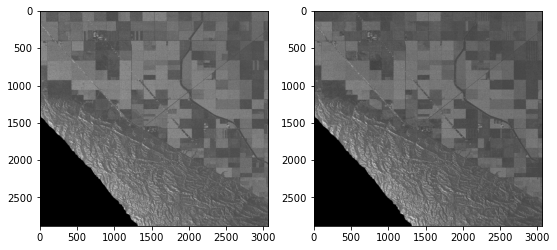

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].imshow(scale_mag(slc1), cmap="gray")
axes[1].imshow(scale_mag(slc2), cmap="gray");

Note that where the flight line ends, there will just be 0s in the SLC.

Now, the interferogram, $I$,

$$
I_{1 2} = C_1 C_2 e^{j (\phi_1 - \phi_2)}
$$

can be formed as `slc1 * slc2.conj()`, usually with extra looks taken. The SLCs can be 2x upsampled to avoid spatial aliasing, though this won't be visible in this example.

We'll take 5 looks in each direction to return the pixel spacing back to 30 meters and see what the result looks like

In [136]:
looks = 5, 5

ifg_full_res = slc1 * slc2.conj()
ifg_looked = utils.take_looks(ifg_full_res, *looks)
# To save to a flat binary file:
# ifg_looked.tofile("interferogram.int")

print(ifg_looked.shape)

(576, 612)


In [137]:
# To get correlation:
amp1 = np.sqrt(utils.take_looks(np.abs(slc1)**2, *looks))
amp2 = np.sqrt(utils.take_looks(np.abs(slc2)**2, *looks))
cor = np.abs(ifg_looked) / (np.finfo('float32').eps + amp1 * amp2)

Let's plot the phase to see how it turned out

In [83]:
try:
    # to get 'dismph' colormap
    from apertools import plotting
    cmap = 'dismph'
except ImportError:
    cmap = 'hsv'

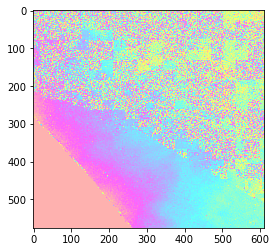

In [30]:
phase = np.angle(ifg_looked)

fig, ax = plt.subplots()
ax.imshow(phase, cmap=cmap, interpolation="nearest");

Similar results for CPU computed inteferograms

In [ ]:
!uageocode Snjoaq_14511_13129_010_130719_L090_CX_129_03.h5 -o cpu1.slc
!uageocode Snjoaq_14511_13165_012_131031_L090_CX_129_03.h5 -o cpu2.slc

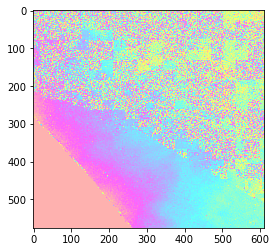

In [131]:
slc1_cpu = np.fromfile("cpu1.slc", dtype="complex64").reshape((rows, cols))
slc2_cpu = np.fromfile("cpu2.slc", dtype="complex64").reshape((rows, cols))
ifg_cpu = utils.take_looks(slc1_cpu * slc2_cpu.conj(), *looks)

fig, ax = plt.subplots()
ax.imshow(np.angle(ifg_cpu), cmap="dismph", interpolation="nearest");

<div class="alert alert-info">
Mixing GPU output with CPU output
</div>
The two versions seem to be compatible to form interferograms if, for some reason, you switch versions after processing a subset.

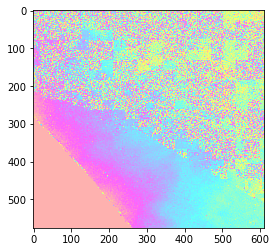

In [138]:
ifg_cpu_gpu = utils.take_looks(slc1_cpu * slc2.conj(), *looks)

fig, ax = plt.subplots()
ax.imshow(np.angle(ifg_cpu_gpu), cmap="dismph", interpolation="nearest");